In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error


from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse
import numpy as np

from datetime import datetime



In [2]:
df = pd.read_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/time_series_dataframe.csv', index_col=1,parse_dates=True)

In [3]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

In [4]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)

In [5]:
df.index=pd.to_datetime(df.index)

In [6]:
df.head()

,CS_HPA_20_cities,CS_HP,UNEMPLOY,LF_Part,Y10_CMT,Y30_fixed_mortgage_rate,UNEMPLOY_adj,LF_Part_adj,year,month
Date,,,,,,,,,,
2000-01-01,100.589697,100.552,4.5,67.3,6.661000,8.2100,4.5,67.3,2000,Jan
2000-02-01,101.692479,101.339,4.4,67.3,6.519500,8.3250,4.4,67.3,2000,Feb
2000-03-01,102.783829,102.127,4.3,67.3,6.256522,8.2400,4.3,67.3,2000,Mar
2000-04-01,103.996444,102.922,3.7,67.3,5.990526,8.1525,3.7,67.3,2000,Apr
2000-05-01,105.252818,103.677,3.8,67.1,6.440455,8.5150,3.8,67.1,2000,May


In [7]:
target_index ='Y10_CMT'

In [8]:
index_title ='Ten Year Constant Maturity Treasury'

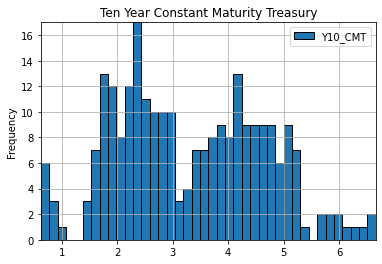

In [9]:
df.plot.hist(y=target_index,grid=True,bins=40,edgecolor='k',title=index_title).autoscale(enable=True,axis='both',tight=True)
plt.show()

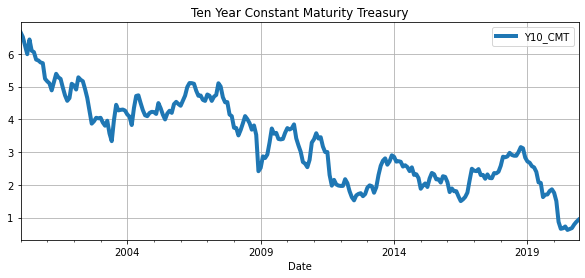

In [10]:
df.plot.line(y=target_index, figsize=(10,4),lw=4, grid=True, title=index_title)
plt.show()

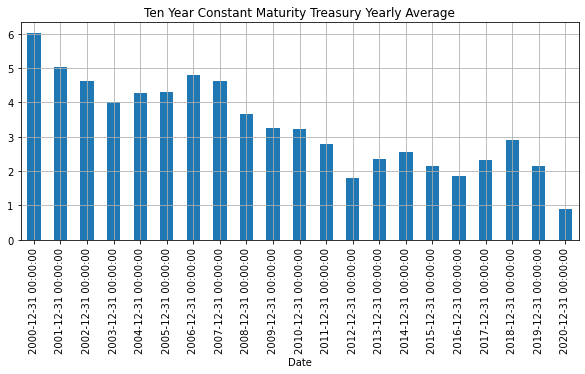

In [11]:
df[target_index].resample('A').mean().plot.bar(figsize=(10,4),grid=True, title=index_title + ' Yearly Average')
plt.show()

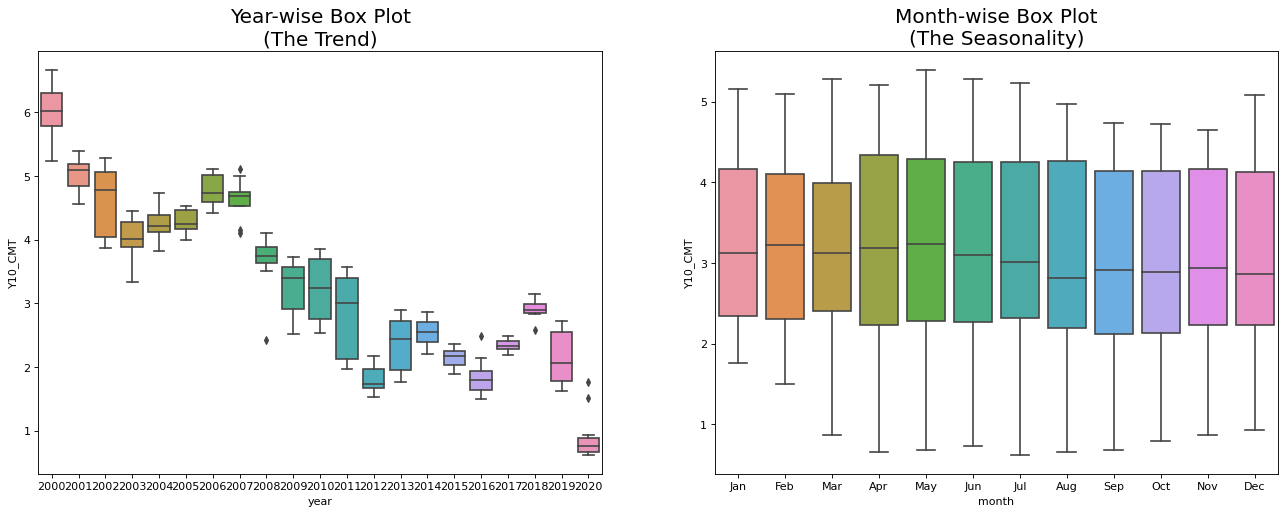

In [12]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y=target_index, data=df, ax=axes[0])
sns.boxplot(x='month', y=target_index, data=df.loc[~df.year.isin([2000]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

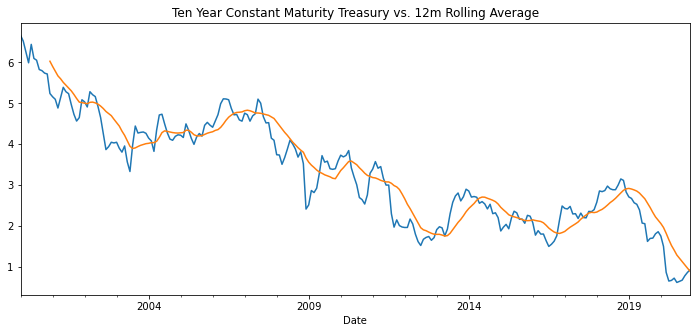

In [13]:
df[target_index].plot(figsize=(12,5))
df[target_index].rolling(window=12).mean().plot(title=index_title + ' vs. 12m Rolling Average')
plt.show()

In [14]:
cycle, trend = hpfilter(df[target_index], lamb=129600)

In [15]:
df['Trend']=trend

In [16]:
df['Cycle']=cycle

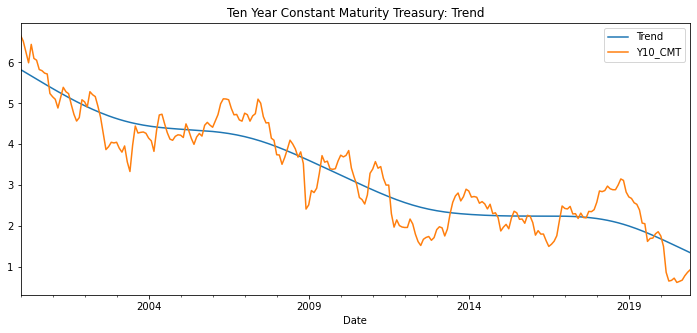

In [17]:
df[['Trend',target_index]].plot(figsize=(12,5),title=index_title + ': Trend')
plt.show()

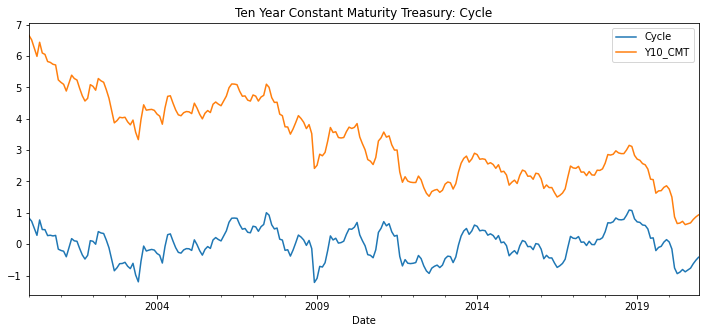

In [18]:
df[['Cycle',target_index]].plot(figsize=(12,5),title=index_title + ': Cycle')
plt.show()

In [19]:
#ETS

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,12

In [21]:
result_additive = seasonal_decompose(df[target_index], model = 'additive')

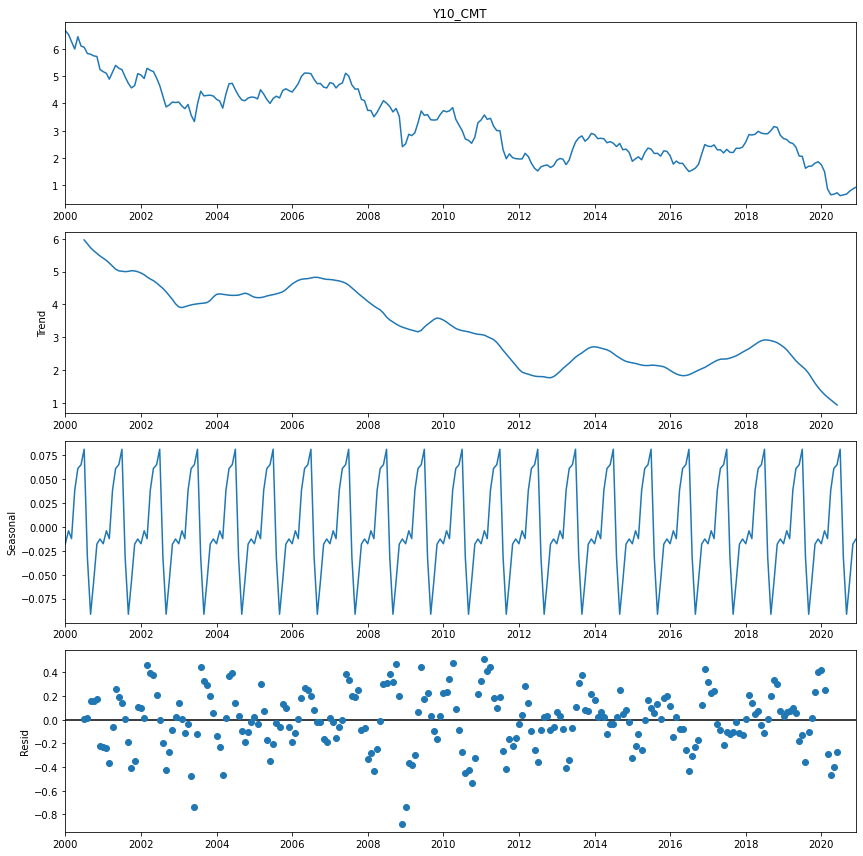

In [22]:
result_additive.plot();

In [23]:
result_multiplicative = seasonal_decompose(df[target_index], model = 'multiplicative')

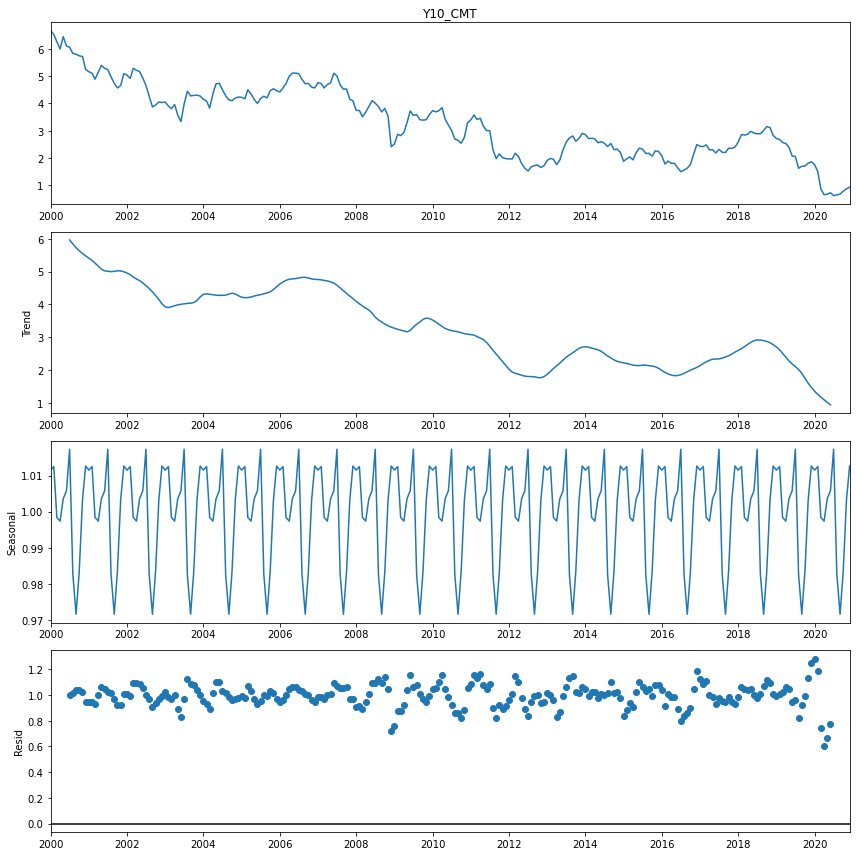

In [24]:
result_multiplicative.plot();

In [25]:
#EWMA

In [26]:
df['6-month--SMA']=df[target_index].rolling(window=6).mean()

In [27]:
df['12-month--SMA']=df[target_index].rolling(window=12).mean()

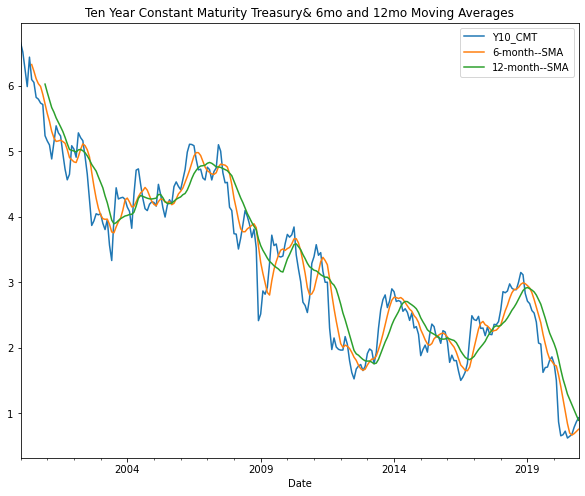

In [28]:
df[[target_index,'6-month--SMA','12-month--SMA']].plot(figsize=(10,8),title=index_title + '& 6mo and 12mo Moving Averages')
plt.show()

In [29]:
df['EWMA-12']=df[target_index].ewm(span=12, adjust=True).mean()

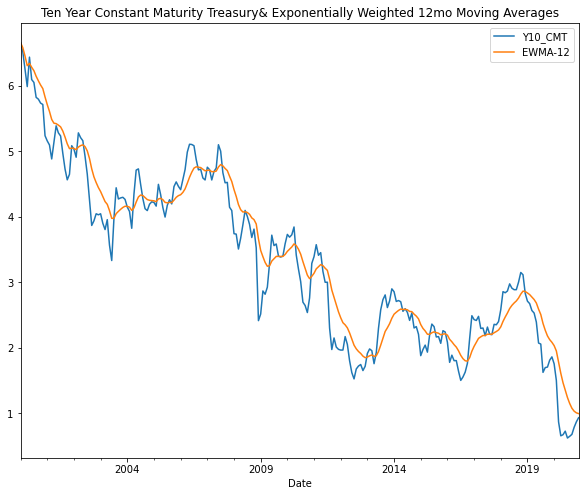

In [30]:
df[[target_index,'EWMA-12']].plot(figsize=(10,8),title=index_title + '& Exponentially Weighted 12mo Moving Averages')
plt.show()

In [31]:
#Holt-Winters method

In [32]:
df.index.freq= 'MS'

In [33]:
span = 12
alpha = 2/(span+1)

In [34]:
model = SimpleExpSmoothing(df[target_index])

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [35]:
fitted_model=model.fit(smoothing_level=alpha, optimized = False)

In [36]:
df['SES12']=fitted_model.fittedvalues.shift(-1)

In [37]:
model =  ExponentialSmoothing(df[target_index],trend='add')

In [38]:
fitted_model = model.fit()

In [39]:
df['DES_add_12']=fitted_model.fittedvalues.shift(-1)

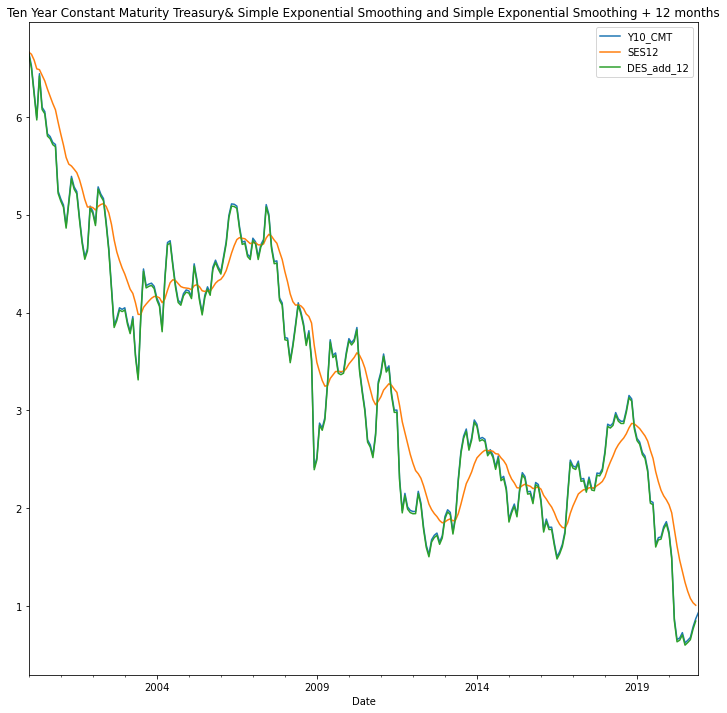

In [40]:
df[[target_index, 'SES12','DES_add_12']].plot(title=index_title + '& Simple Exponential Smoothing and Simple Exponential Smoothing + 12 months')
plt.show()

In [41]:
model =  ExponentialSmoothing(df[target_index],trend='add',seasonal='add', seasonal_periods=12)

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [42]:
fitted_model = model.fit()

In [43]:
df['TES_mul_12']=fitted_model.fittedvalues.shift(-1)

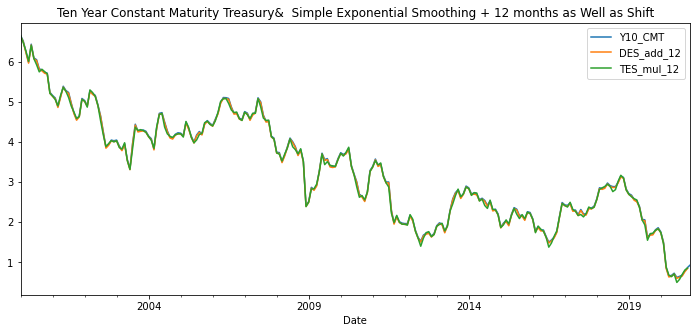

In [44]:
df[[target_index,'DES_add_12','TES_mul_12']].plot(figsize=(12,5),title=index_title + '&  Simple Exponential Smoothing + 12 months as Well as Shift')
plt.show()

In [45]:
df.drop(labels=['Trend','Cycle','6-month--SMA','12-month--SMA','EWMA-12','SES12','DES_add_12','TES_mul_12'],axis=1, inplace=True)

In [46]:
train_data=df.iloc[:201]
test_data=df.iloc[200:]

In [47]:
fitted_model=ExponentialSmoothing(train_data[target_index],
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12).fit()

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [48]:
test_predictions=fitted_model.forecast(52)

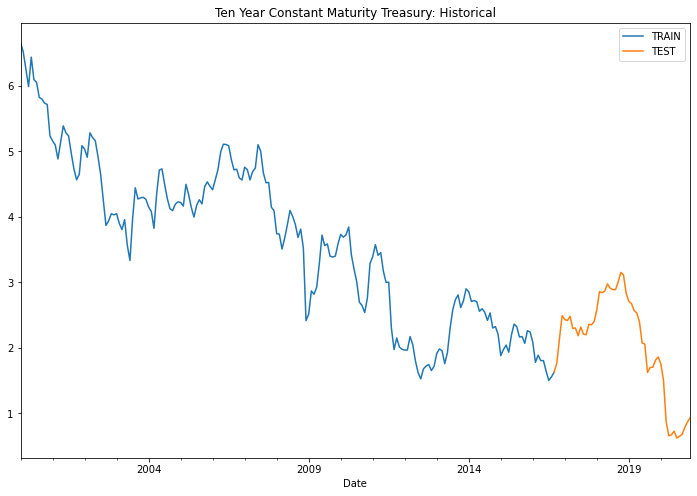

In [49]:
train_data[target_index].plot(legend=True, label='TRAIN', figsize=(12,8),title=index_title + ': Historical')
test_data[target_index].plot(legend=True, label='TEST')
plt.show()

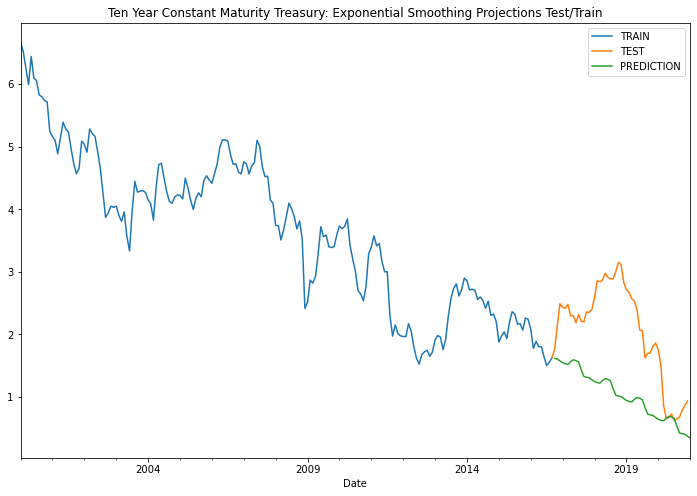

In [50]:
train_data[target_index].plot(legend=True, label='TRAIN', figsize=(12,8),title=index_title + ': Exponential Smoothing Projections Test/Train')
test_data[target_index].plot(legend=True, label='TEST')
test_predictions.plot(legend=True, label='PREDICTION')
plt.show()

In [51]:
## Evaulation

In [52]:
mean_absolute_error(test_data[target_index],test_predictions)

1.0319916351457563

In [53]:
mean_squared_error(test_data[target_index],test_predictions)

1.4186402951394075

In [54]:
np.sqrt(mean_squared_error(test_data[target_index],test_predictions))

1.1910668726563625

In [55]:
final_model=ExponentialSmoothing(df[target_index], 
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12).fit()

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [56]:
forecast_predictions=final_model.forecast(36)

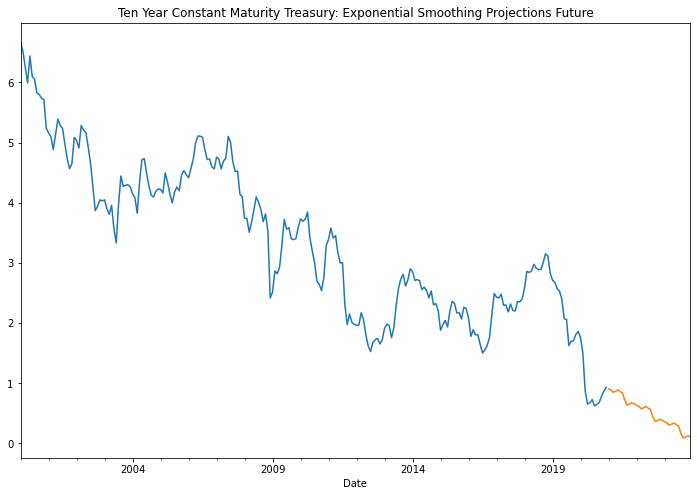

In [57]:
df[target_index].plot(figsize=(12,8),title=index_title + ': Exponential Smoothing Projections Future')
forecast_predictions.plot()
plt.show()

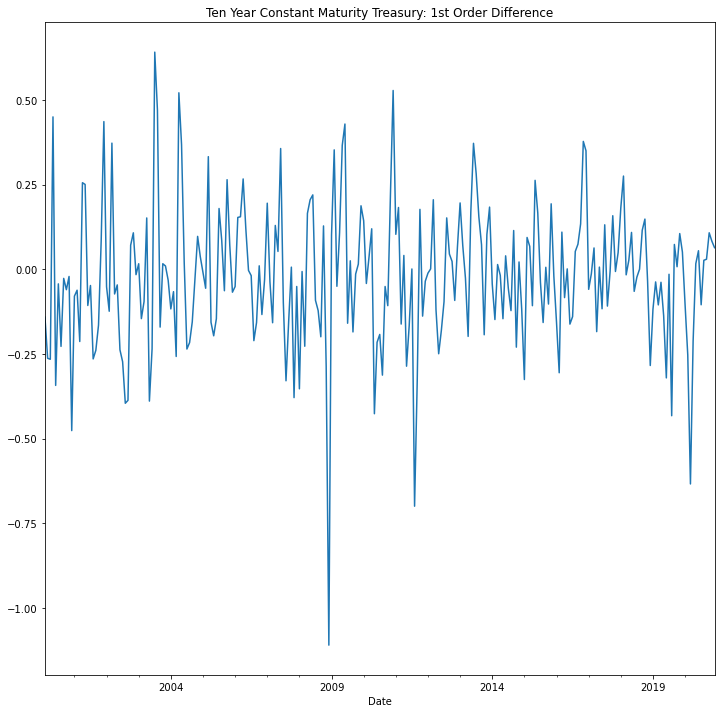

In [58]:
diff(df[target_index],k_diff=1).plot(title=index_title + ': 1st Order Difference')
plt.show()

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
#acf(df[target_index])

In [61]:
#pacf_yw(df[target_index], nlags=252, method='mle')

In [62]:
#pacf_ols(df[target_index], nlags=251)

In [63]:
from pandas.plotting import lag_plot

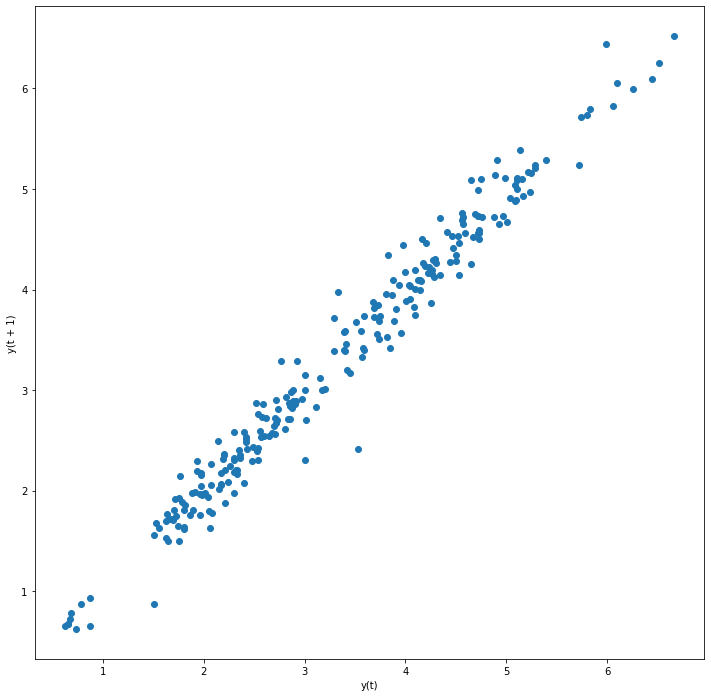

In [64]:
lag_plot(df[target_index])
plt.show()

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

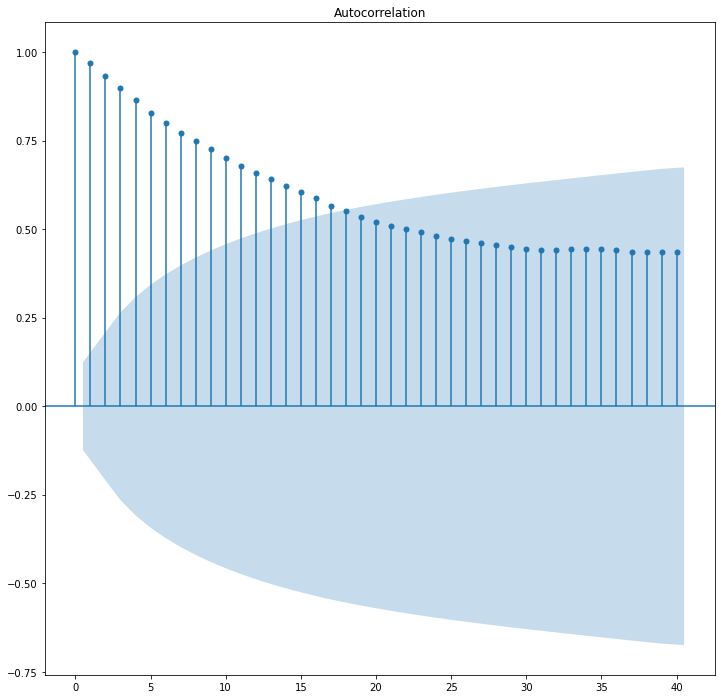

In [66]:
plot_acf(df[target_index],lags=40)
plt.show()

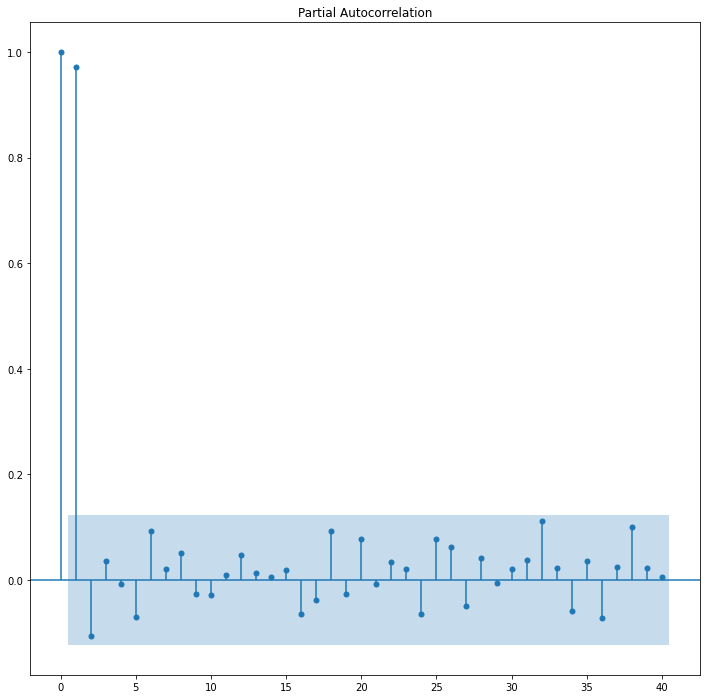

In [67]:
plot_pacf(df[target_index],lags=40)
plt.show()

In [68]:
#AR model

In [69]:
from statsmodels.tsa.ar_model import AR, ARResults

In [70]:
train =df.iloc[:200]

In [71]:
test =df.iloc[200:]

In [72]:
model = AR(train[target_index])

In [73]:
AR1fit = model.fit(maxlag=1)

In [74]:
AR1fit.aic

-3.0297332189808475

In [75]:
AR1fit.k_ar

1

In [76]:
AR1fit.params

const         0.060421
L1.Y10_CMT    0.976389
dtype: float64

In [77]:
start=len(train)

In [78]:
end=len(train)+len(test)-1

In [79]:
#AR1fit.predict(start=start, end=end)

In [80]:
predictions1 = AR1fit.predict(start=start, end=end)

In [81]:
predictions1 = predictions1.rename('AR{1} Predictions')

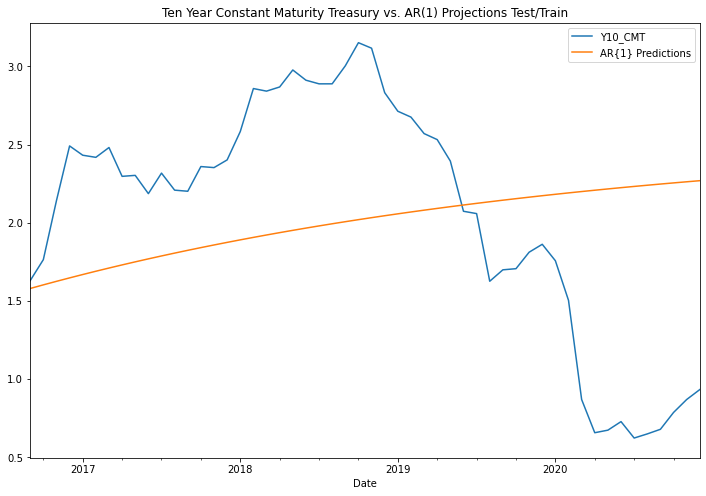

In [82]:
test[target_index].plot(figsize=(12,8),legend=True, title=index_title + ' vs. AR(1) Projections Test/Train')
predictions1.plot(legend=True);

In [83]:
model = AR(train[target_index])

In [84]:
AR2fit = model.fit(maxlag=2)

In [85]:
AR2fit.params

const         0.069428
L1.Y10_CMT    1.159937
L2.Y10_CMT   -0.184643
dtype: float64

In [86]:
predictions2 = AR2fit.predict(start=start, end=end)

In [87]:
predictions2 = predictions2.rename('AR{2} Predictions')

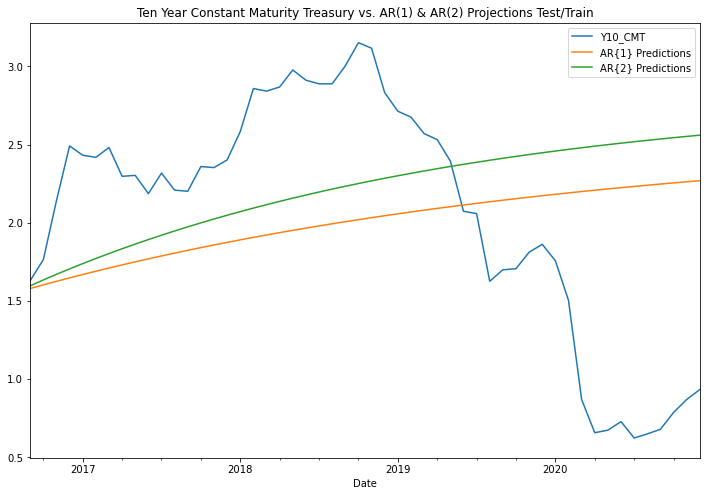

In [88]:
test[target_index].plot(figsize=(12,8),legend=True,title=index_title + ' vs. AR(1) & AR(2) Projections Test/Train')
predictions1.plot(legend=True)
predictions2.plot(legend=True);

In [89]:
model = AR(train[target_index])

In [90]:
ARfit = model.fit(ic='t-stat')

In [91]:
ARfit.params

const         0.056545
L1.Y10_CMT    1.183015
L2.Y10_CMT   -0.331457
L3.Y10_CMT    0.126751
dtype: float64

In [92]:
predictions3=ARfit.predict(start,end)

In [93]:
predictions3=predictions3.rename('AR(3) Predictions')

In [94]:
from sklearn.metrics import mean_squared_error

In [95]:
labels = ['AR1','AR2','AR3']

In [96]:
preds = [predictions1,predictions2,predictions3]

In [97]:
for i in range(3):
    error = np.sqrt(mean_squared_error(test[target_index], preds[i]))
    print(f' {labels[i]} RMSE was: {error}')

 AR1 RMSE was: 0.8851966546488957
 AR2 RMSE was: 0.9384405140477314
 AR3 RMSE was: 0.8858560749792264


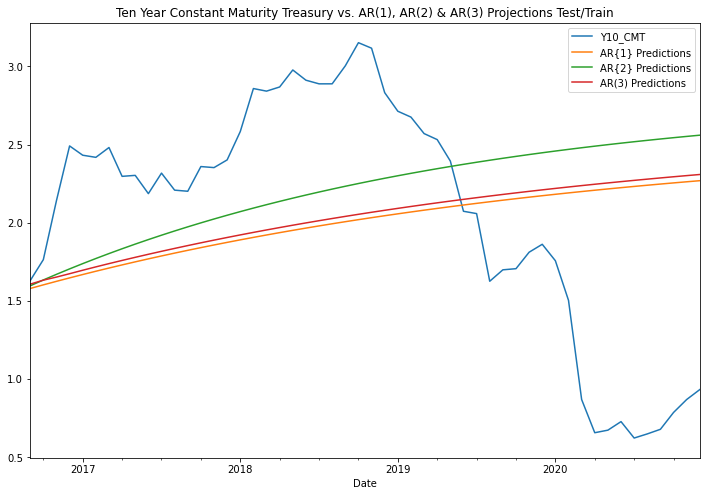

In [98]:
test[target_index].plot(figsize=(12,8),legend=True,title=index_title + ' vs. AR(1), AR(2) & AR(3) Projections Test/Train')
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions3.plot(legend=True);

In [99]:
#Forecasting

In [100]:
model=AR(df[target_index])

In [101]:
ARfit = model.fit(maxlag=14)

In [102]:
forcasted_values=ARfit.predict(start=len(df), end= len(df)+36).rename('Forecast')

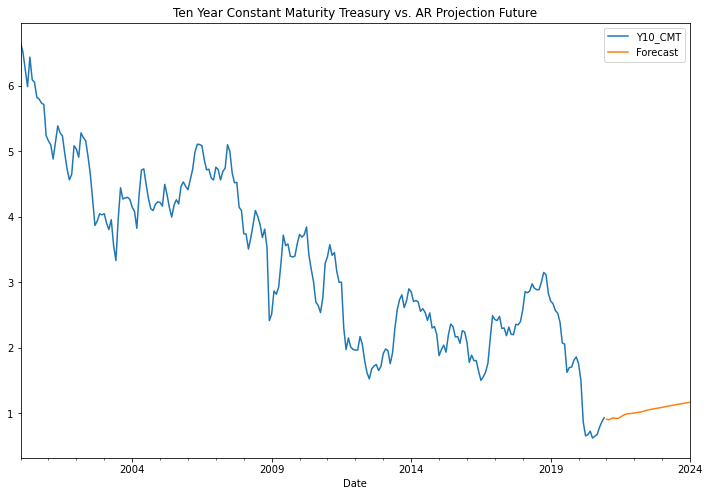

In [103]:
df[target_index].plot(figsize=(12,8), legend=True,title=index_title + ' vs. AR Projection Future')
forcasted_values.plot(legend=True)
plt.show()

In [104]:
#Descriptive statistics and tests

In [105]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

In [106]:
dftest=adfuller(df[target_index])
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

In [107]:
for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

ADF test statistic       -1.769493
p-value                   0.395709
# lags used               2.000000
# observations          249.000000
critical value (1%)      -3.456888
critical value (5%)      -2.873219
critical value (10%)     -2.572994
dtype: float64


In [108]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [109]:
adf_test(df[target_index])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.769493
p-value                   0.395709
# lags used               2.000000
# observations          249.000000
critical value (1%)      -3.456888
critical value (5%)      -2.873219
critical value (10%)     -2.572994
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


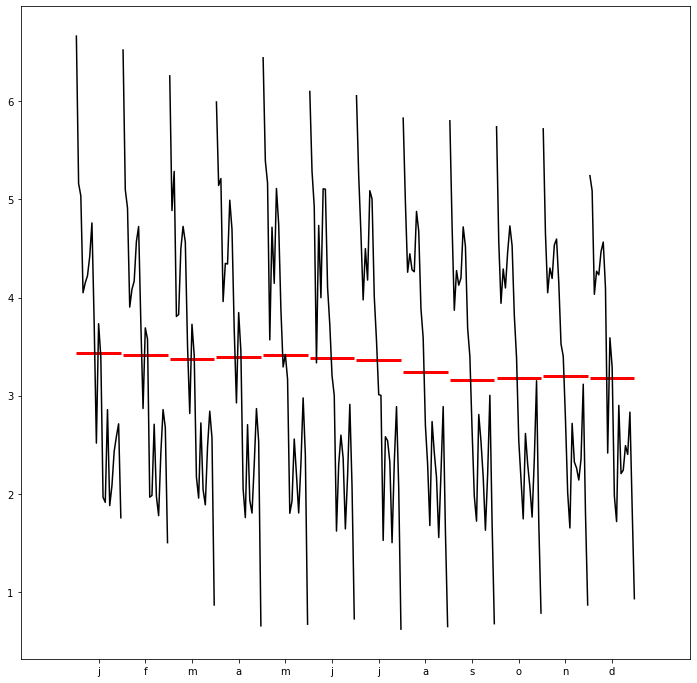

In [110]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
month_plot(df[target_index]);

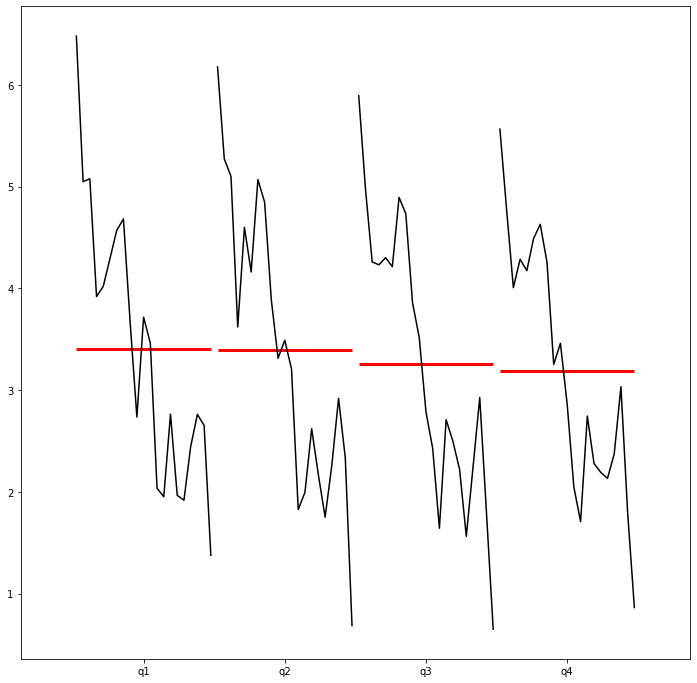

In [111]:
dfq = df[target_index].resample(rule='Q').mean()
quarter_plot(dfq);

In [112]:
#ARIMA orders

In [113]:
from pmdarima import auto_arima

In [114]:
stepwise_fit=auto_arima(df[target_index],start_p=0, start_q=0, max_p=6, max_q=3, seasonal = False, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.281, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.362, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-78.667, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.334, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-77.565, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-77.642, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.678, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-77.388, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-77.399, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.436, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-75.970, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.957 seconds


In [115]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  41.339
Date:                Mon, 04 Oct 2021   AIC                            -78.678
Time:                        17:25:24   BIC                            -71.627
Sample:                             0   HQIC                           -75.841
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2568      0.052      4.893      0.000       0.154       0.360
sigma2         0.0421      0.003     16.615      0.000       0.037       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                78.47
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [118]:
#ARMA

In [119]:
auto_arima(df[target_index], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  41.339
Date:                Mon, 04 Oct 2021   AIC                            -78.678
Time:                        17:25:26   BIC                            -71.627
Sample:                             0   HQIC                           -75.841
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2568      0.052      4.893      0.000       0.154       0.360
sigma2         0.0421      0.003     16.615      0.000       0.037       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                78.47
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
train = df.iloc[:200]
test = df.iloc[200:]

In [121]:
model=ARMA(train[target_index], order=(0,1,1))

In [122]:
results=model.fit()

In [123]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                Y10_CMT   No. Observations:                  200
Model:                     ARMA(0, 1)   Log Likelihood                -210.433
Method:                       css-mle   S.D. of innovations              0.690
Date:                Mon, 04 Oct 2021   AIC                            426.865
Time:                        17:25:26   BIC                            436.760
Sample:                    01-01-2000   HQIC                           430.870
                         - 08-01-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.6383      0.093     39.166      0.000       3.456       3.820
ma.L1.Y10_CMT     0.9086      0.022     41.460      0.000       0.866       0.952
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.1005           +0.0000j            1.1005            0.5000
-----------------------------------------------------------------------------
"""

In [124]:
start=len(train)

In [125]:
end=len(train) +len(test)-1

In [126]:
predictions = results.predict(start,end,typ='levels').rename('ARMA (0,1) Prediction')

In [127]:
error=rmse(test[target_index],predictions)

In [128]:
error

1.7288438682035248

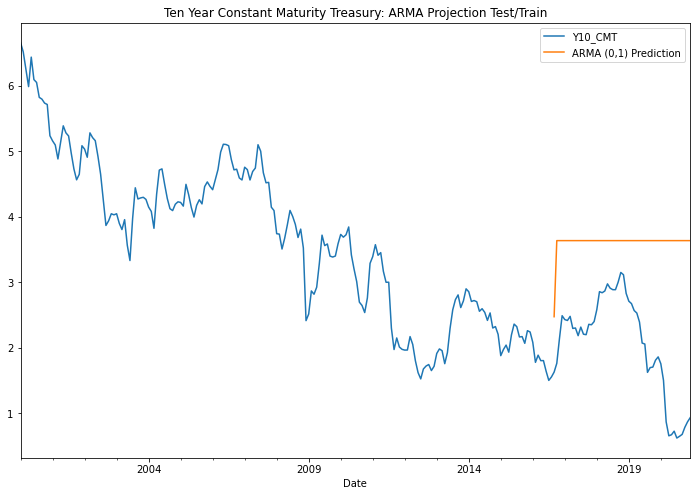

In [129]:
df[target_index].plot(figsize=(12,8), legend=True, title=index_title + ': ARMA Projection Test/Train')
predictions.plot(legend=True)
plt.show()

In [130]:
#ARIMA

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose

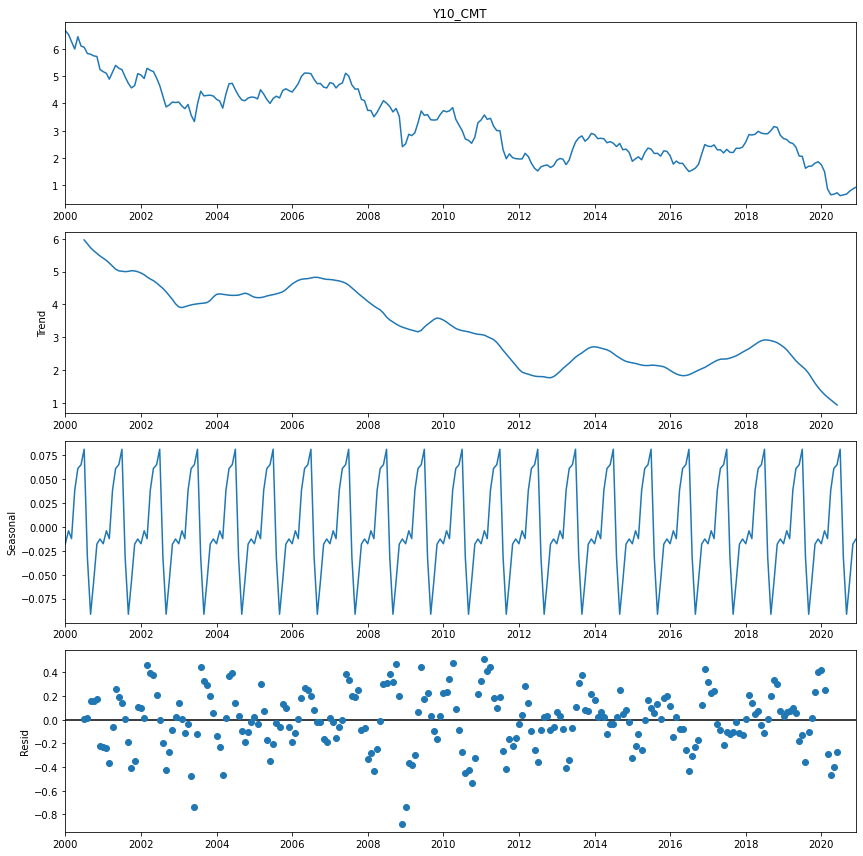

In [132]:
result = seasonal_decompose(df[target_index], model ='add')
result.plot();

In [133]:
auto_arima(df[target_index],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  41.339
Date:                Mon, 04 Oct 2021   AIC                            -78.678
Time:                        17:25:28   BIC                            -71.627
Sample:                             0   HQIC                           -75.841
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2568      0.052      4.893      0.000       0.154       0.360
sigma2         0.0421      0.003     16.615      0.000       0.037       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                78.47
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
df['Diff_1'] =diff(df[target_index], k_diff=2)

In [135]:
adf_test(df['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.023899e+01
p-value                 4.804780e-18
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


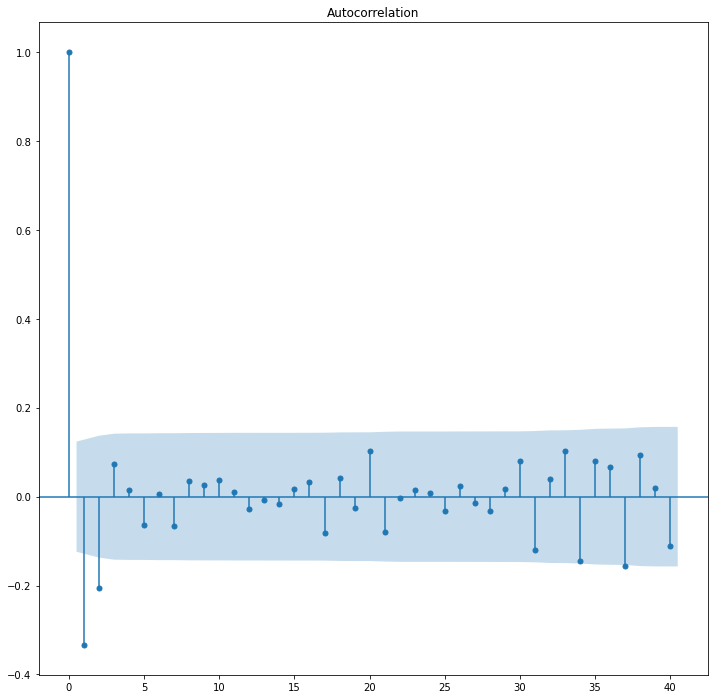

In [136]:
plot_acf(df['Diff_1'].dropna(),lags=40);

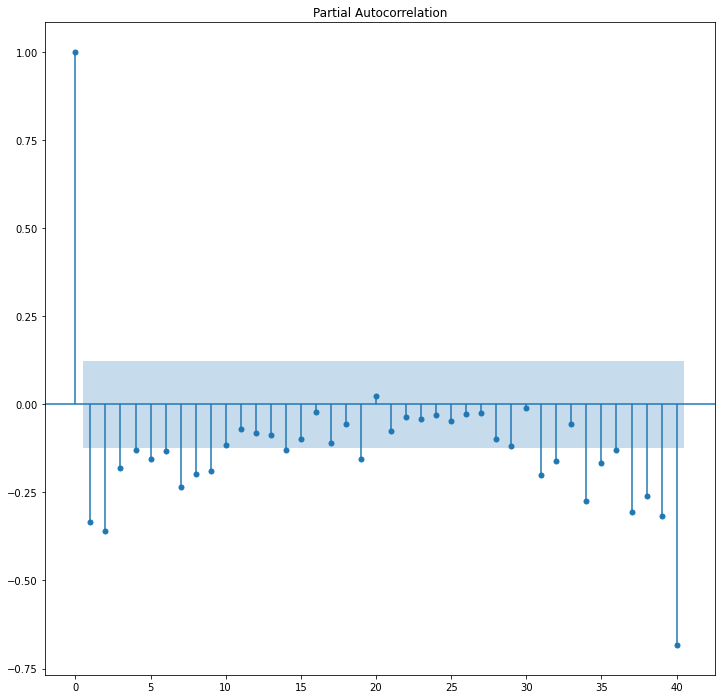

In [137]:
plot_pacf(df['Diff_1'].dropna(),lags=40);

In [138]:
stepwise_fit=auto_arima(df[target_index], start_p=0, start_q=0, max_p=12, max_q=12,
                       seasonal = False, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.281, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.362, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-78.667, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.334, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-77.565, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-77.642, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.678, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-77.388, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-77.399, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.436, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-75.970, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.871 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  41.339
Date:                Mon, 04 Oct 2021   AIC                            -78.678
Time:                        17:25:29   BIC                            -71.627
Sample:                             0   HQIC                           -75.841
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2568      0.052      4.893      0.000       0.154       0.360
sigma2         0.0421      0.003     16.615      0.000       0.037       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                78.47
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
train = df.iloc[:200]
test = df.iloc[200:]

In [140]:
model=ARIMA(train[target_index], order=(0,1,1))

In [141]:
results=model.fit()

In [142]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Y10_CMT   No. Observations:                  199
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  24.527
Method:                       css-mle   S.D. of innovations              0.214
Date:                Mon, 04 Oct 2021   AIC                            -43.054
Time:                        17:25:29   BIC                            -33.174
Sample:                    02-01-2000   HQIC                           -39.055
                         - 08-01-2016                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0256      0.019     -1.371      0.170      -0.062       0.011
ma.L1.D.Y10_CMT     0.2339      0.077      3.026      0.002       0.082       0.385
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -4.2748           +0.0000j            4.2748            0.5000
-----------------------------------------------------------------------------
"""

In [143]:
start=len(train)

In [144]:
end=len(train) +len(test)-1

In [145]:
predictions = results.predict(start,end, typ='levels').rename('ARIMA (0,1,1) Prediction')

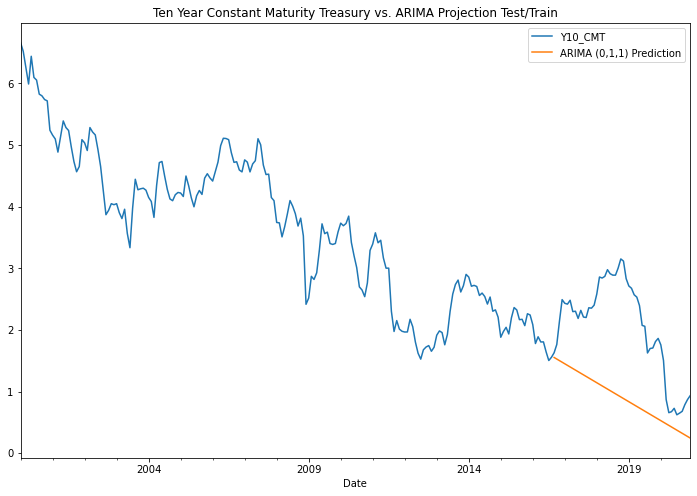

In [146]:
df[target_index].plot(legend=True, figsize=(12,8),title=index_title + ' vs. ARIMA Projection Test/Train')
predictions.plot(legend=True)
plt.show()

In [147]:
error=rmse(test[target_index],predictions)

In [148]:
error

1.3081421251520902

In [149]:
#FORECAST

In [150]:
model=ARIMA(df[target_index], order=(3,1,1))

In [151]:
results=model.fit()

In [152]:
fcast=results.predict(start=len(df), end=len(df)+24,typ='levels').rename('ARIMA(0,1,1)')

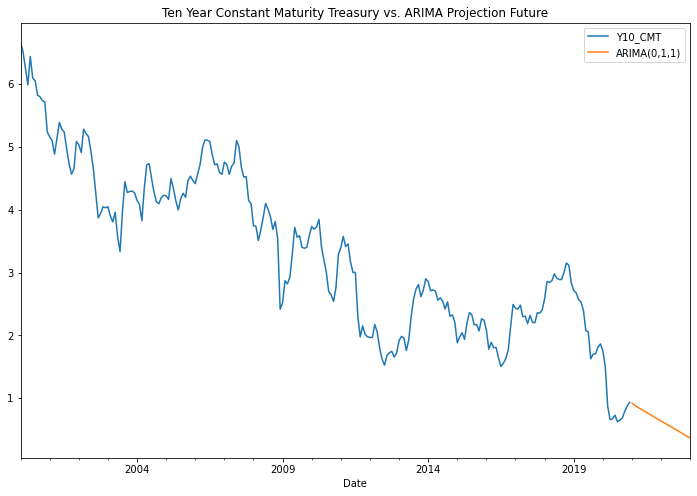

In [153]:
df[target_index].plot(legend=True, figsize=(12,8),title=index_title + ' vs. ARIMA Projection Future')
fcast.plot(legend=True);

In [154]:
#SARIMA Models

In [155]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [156]:
from statsmodels.tsa.seasonal import seasonal_decompose 

In [157]:
auto_arima(df[target_index], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  41.339
Date:                Mon, 04 Oct 2021   AIC                            -78.678
Time:                        17:25:32   BIC                            -71.627
Sample:                             0   HQIC                           -75.841
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2568      0.052      4.893      0.000       0.154       0.360
sigma2         0.0421      0.003     16.615      0.000       0.037       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                78.47
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
train = df.iloc[:200]
test = df.iloc[200:]

In [159]:
model=SARIMAX(df[target_index], order=(0,1,3), seasonal_order=(1,0,0,12))

In [160]:
results=model.fit()

In [161]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Y10_CMT   No. Observations:                  252
Model:             SARIMAX(0, 1, 3)x(1, 0, [], 12)   Log Likelihood                  41.706
Date:                             Mon, 04 Oct 2021   AIC                            -73.413
Time:                                     17:25:32   BIC                            -55.785
Sample:                                 01-01-2000   HQIC                           -66.319
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2433      0.055      4.428      0.000       0.136       0.351
ma.L2         -0.0488      0.067     -0.726      0.468      -0.181       0.083
ma.L3          0.0074      0.069      0.107      0.915      -0.128       0.143
ar.S.L12      -0.0035      0.065     -0.053      0.957      -0.131       0.124
sigma2         0.0420      0.003     15.140      0.000       0.037       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                73.60
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
start=len(train)

In [163]:
end=len(train) +len(test)-1

In [164]:
predictions=results.predict(start, end,typ='levels').rename('SARIMA Predictions')

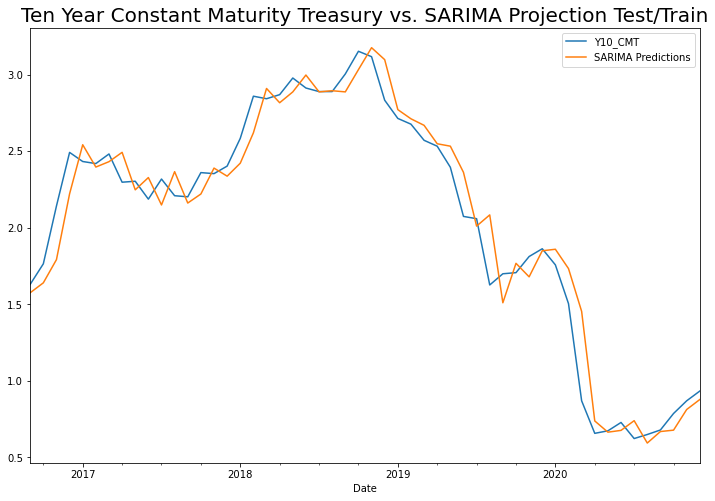

In [165]:
test[target_index].plot(legend=True, figsize=(12,8))
plt.title(index_title + ' vs. SARIMA Projection Test/Train', fontdict = {'fontsize' : 20})
predictions.plot(legend=True)
plt.savefig('image1.jpg');

In [166]:
error=rmse(test[target_index],predictions)

In [167]:
error

0.16474785176461212

In [168]:
#Forecast

In [169]:
model= SARIMAX(df[target_index], order=(3,1,1), seasonal_order=(1,0,0,12))
results=model.fit()

In [170]:
fcast= results.predict(start=len(df), end=len(df)+35,typ='levels').rename('SARIMA FORECAST')

In [171]:
len(fcast)

36

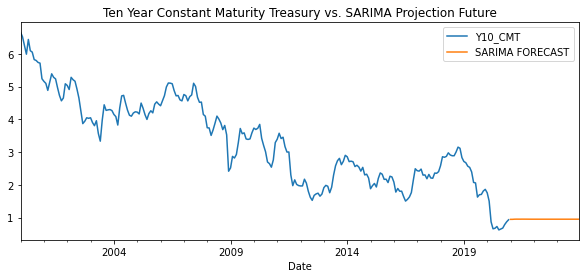

In [172]:
df[target_index].plot(legend=True, figsize=(10,4),title=index_title + ' vs. SARIMA Projection Future')
fcast.plot(legend=True);

In [173]:
fcast

2021-01-01    0.946408
2021-02-01    0.946819
2021-03-01    0.951081
2021-04-01    0.952464
2021-05-01    0.952300
2021-06-01    0.952059
2021-07-01    0.952573
2021-08-01    0.952444
2021-09-01    0.952303
2021-10-01    0.951792
2021-11-01    0.951397
2021-12-01    0.951094
2022-01-01    0.951033
2022-02-01    0.951032
2022-03-01    0.951011
2022-04-01    0.951005
2022-05-01    0.951005
2022-06-01    0.951007
2022-07-01    0.951004
2022-08-01    0.951005
2022-09-01    0.951005
2022-10-01    0.951008
2022-11-01    0.951010
2022-12-01    0.951011
2023-01-01    0.951011
2023-02-01    0.951011
2023-03-01    0.951012
2023-04-01    0.951012
2023-05-01    0.951012
2023-06-01    0.951012
2023-07-01    0.951012
2023-08-01    0.951012
2023-09-01    0.951012
2023-10-01    0.951012
2023-11-01    0.951012
2023-12-01    0.951012
Freq: MS, Name: SARIMA FORECAST, dtype: float64

In [174]:
### Auto-ARIMA

In [175]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df[target_index], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-77.565, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-67.281, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76.362, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-78.667, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.334, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-77.642, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.678, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-77.388, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-77.399, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-76.436, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-75.970, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.924 seconds
                               SARIMAX Results                                
Dep. Variable:           

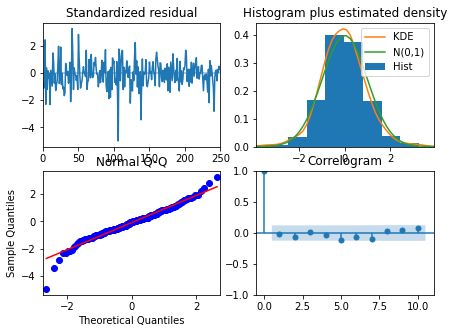

In [176]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [177]:
df[target_index]

Date
2000-01-01    6.661000
2000-02-01    6.519500
2000-03-01    6.256522
2000-04-01    5.990526
2000-05-01    6.440455
                ...   
2020-08-01    0.650000
2020-09-01    0.679524
2020-10-01    0.787143
2020-11-01    0.870000
2020-12-01    0.933636
Freq: MS, Name: Y10_CMT, Length: 252, dtype: float64

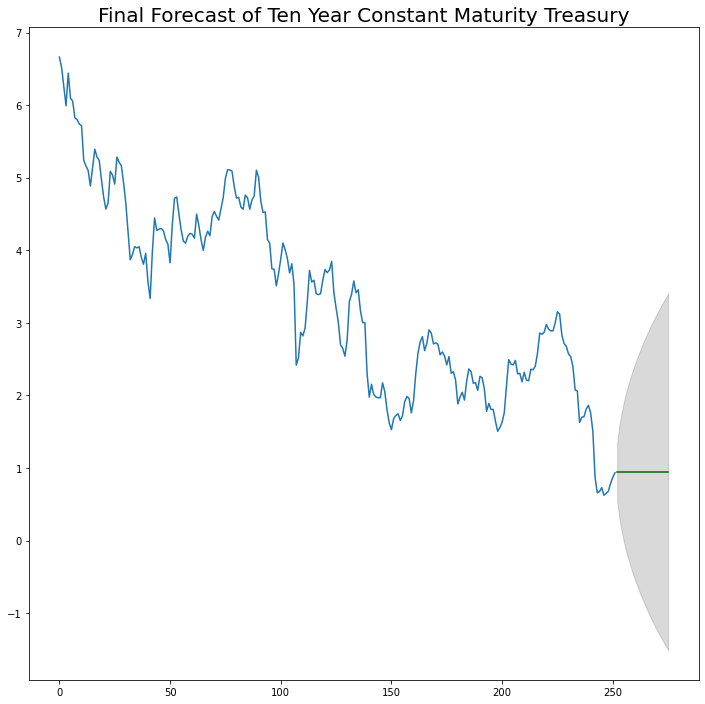

In [178]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df[target_index]), len(df[target_index])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

df.reset_index(inplace=True)

# Plot
plt.plot(df[target_index])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of " + index_title, fontdict = {'fontsize' : 20})
plt.savefig('image2.jpg');

In [179]:
fc_series.to_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/Y10_CMT.csv', header=False)

In [180]:
###Keras

In [181]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [182]:
from keras.models import Sequential
from keras.layers import Dense

In [183]:
model = Sequential()
# 4 Neurons, expecting only 1 feature with input_dim=1
model.add(Dense(4, input_dim=1, activation='relu'))
# 4 Neurons (Play around with this number!)
model.add(Dense(4, activation='relu'))
# One final output of y, so only 1 neuron
model.add(Dense(1, activation='linear'))
# Compil the layers
model.compile(loss='mse', optimizer='adam')

In [184]:
df=df.reset_index()

In [185]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [186]:
model.fit(df.index, df[target_index], epochs=500, verbose=1)

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 8333.0088
Epoch 2/500
8/8 [==============================] - 0s 1ms/step - loss: 7724.1294
Epoch 3/500
8/8 [==============================] - 0s 997us/step - loss: 7163.3813
Epoch 4/500
8/8 [==============================] - 0s 1ms/step - loss: 6631.3896
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 6137.3623
Epoch 6/500
8/8 [==============================] - 0s 997us/step - loss: 5696.4966
Epoch 7/500
8/8 [==============================] - 0s 1ms/step - loss: 5275.5894
Epoch 8/500
8/8 [==============================] - 0s 1ms/step - loss: 4945.6230
Epoch 9/500
8/8 [==============================] - 0s 997us/step - loss: 4648.6162
Epoch 10/500
8/8 [==============================] - 0s 997us/step - loss: 4369.3291
Epoch 11/500
8/8 [==============================] - 0s 1ms/step - loss: 4113.1567
Epoch 12/500
8/8 [==============================] - 0s 1ms/step - loss: 3866.9724
Epoch 13/500
8/8 

8/8 [==============================] - 0s 1ms/step - loss: 4.2365
Epoch 100/500
8/8 [==============================] - 0s 1ms/step - loss: 4.2257
Epoch 101/500
8/8 [==============================] - 0s 2ms/step - loss: 4.2140
Epoch 102/500
8/8 [==============================] - 0s 2ms/step - loss: 4.2020
Epoch 103/500
8/8 [==============================] - 0s 2ms/step - loss: 4.1912
Epoch 104/500
8/8 [==============================] - 0s 3ms/step - loss: 4.1802
Epoch 105/500
8/8 [==============================] - 0s 2ms/step - loss: 4.1700
Epoch 106/500
8/8 [==============================] - 0s 1ms/step - loss: 4.1592
Epoch 107/500
8/8 [==============================] - 0s 2ms/step - loss: 4.1510
Epoch 108/500
8/8 [==============================] - 0s 1ms/step - loss: 4.1364
Epoch 109/500
8/8 [==============================] - 0s 2ms/step - loss: 4.1260
Epoch 110/500
8/8 [==============================] - 0s 1ms/step - loss: 4.1175
Epoch 111/500
8/8 [==============================] - 0

8/8 [==============================] - 0s 1ms/step - loss: 2.9636
Epoch 202/500
8/8 [==============================] - 0s 1ms/step - loss: 2.9509
Epoch 203/500
8/8 [==============================] - 0s 1ms/step - loss: 2.9447
Epoch 204/500
8/8 [==============================] - 0s 1ms/step - loss: 2.9203
Epoch 205/500
8/8 [==============================] - 0s 1ms/step - loss: 2.9107
Epoch 206/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8959
Epoch 207/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8825
Epoch 208/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8691
Epoch 209/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8564
Epoch 210/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8428
Epoch 211/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8291
Epoch 212/500
8/8 [==============================] - 0s 1ms/step - loss: 2.8186
Epoch 213/500
8/8 [==============================] - 0

8/8 [==============================] - 0s 1ms/step - loss: 1.6540
Epoch 304/500
8/8 [==============================] - 0s 1ms/step - loss: 1.6468
Epoch 305/500
8/8 [==============================] - 0s 1ms/step - loss: 1.6302
Epoch 306/500
8/8 [==============================] - 0s 1ms/step - loss: 1.6209
Epoch 307/500
8/8 [==============================] - 0s 2ms/step - loss: 1.6131
Epoch 308/500
8/8 [==============================] - 0s 1ms/step - loss: 1.5982
Epoch 309/500
8/8 [==============================] - 0s 1ms/step - loss: 1.5866
Epoch 310/500
8/8 [==============================] - 0s 2ms/step - loss: 1.5759
Epoch 311/500
8/8 [==============================] - 0s 1ms/step - loss: 1.5623
Epoch 312/500
8/8 [==============================] - 0s 2ms/step - loss: 1.5528
Epoch 313/500
8/8 [==============================] - 0s 997us/step - loss: 1.5407
Epoch 314/500
8/8 [==============================] - 0s 2ms/step - loss: 1.5308
Epoch 315/500
8/8 [==============================] -

8/8 [==============================] - 0s 997us/step - loss: 0.7595
Epoch 406/500
8/8 [==============================] - 0s 1ms/step - loss: 0.7548
Epoch 407/500
8/8 [==============================] - 0s 2ms/step - loss: 0.7470
Epoch 408/500
8/8 [==============================] - 0s 1ms/step - loss: 0.7432
Epoch 409/500
8/8 [==============================] - 0s 1ms/step - loss: 0.7391
Epoch 410/500
8/8 [==============================] - 0s 2ms/step - loss: 0.7337
Epoch 411/500
8/8 [==============================] - 0s 1ms/step - loss: 0.7339
Epoch 412/500
8/8 [==============================] - 0s 1ms/step - loss: 0.7224
Epoch 413/500
8/8 [==============================] - 0s 1ms/step - loss: 0.7187
Epoch 414/500
8/8 [==============================] - 0s 2ms/step - loss: 0.7103
Epoch 415/500
8/8 [==============================] - 0s 1ms/step - loss: 0.7081
Epoch 416/500
8/8 [==============================] - 0s 1ms/step - loss: 0.7008
Epoch 417/500
8/8 [==============================] -

In [187]:
x_for_predictions = np.linspace(0,252,1000)

In [188]:
y_predicted = model.predict(x_for_predictions)

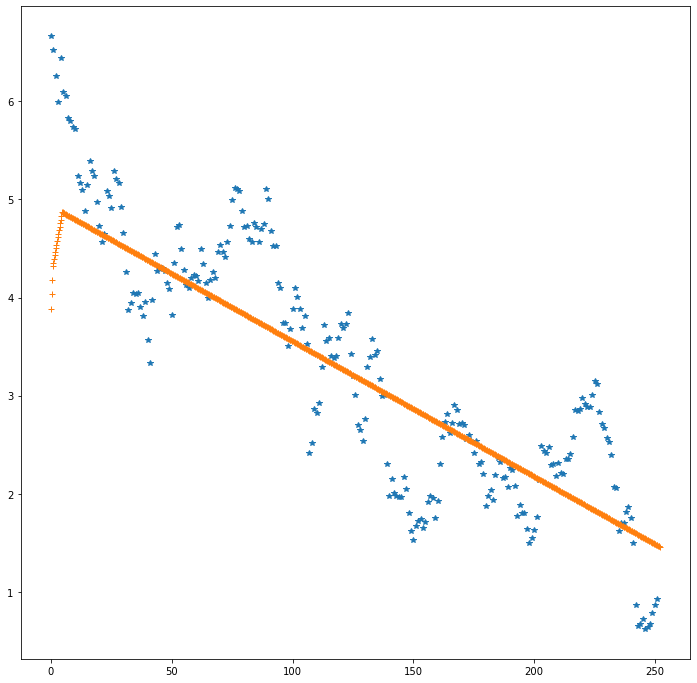

In [189]:
# Original X and Y
plt.plot(df.index, df[target_index],'*')
# Our Model's prediction Line
plt.plot(x_for_predictions,y_predicted,'+')

In [190]:
# start full Keras

In [191]:
df = pd.read_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/time_series_dataframe.csv', index_col=1,parse_dates=True)

In [192]:
df=df.reset_index()

In [193]:
df.drop(labels=(['Date','Unnamed: 0','UNEMPLOY','CS_HPA_20_cities','LF_Part','CS_HP','Y30_fixed_mortgage_rate', 'UNEMPLOY_adj','LF_Part_adj']),axis=1,inplace=True)

In [194]:
train_len = len(df)-36

In [195]:
train = df.iloc[:train_len]
test = df.iloc[train_len:]

In [196]:
from sklearn.preprocessing import MinMaxScaler

In [197]:
scaler = MinMaxScaler()

In [198]:
scaler.fit(train)

MinMaxScaler()

In [199]:
scaled_train = scaler.transform(train)

In [200]:
scaled_test = scaler.transform(test)

In [201]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [202]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [203]:
n_input=12
n_features =1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [204]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [205]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [206]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0159
Epoch 2/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0063
Epoch 3/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0061
Epoch 4/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0059
Epoch 5/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 6/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 7/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 8/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 9/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 10/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 11/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 12/30
204/204 [==============================] - 1s 3ms/step - loss: 0.0027
Epoch 13/30
204/204 [====

In [207]:
model.history.history.keys()

dict_keys(['loss'])

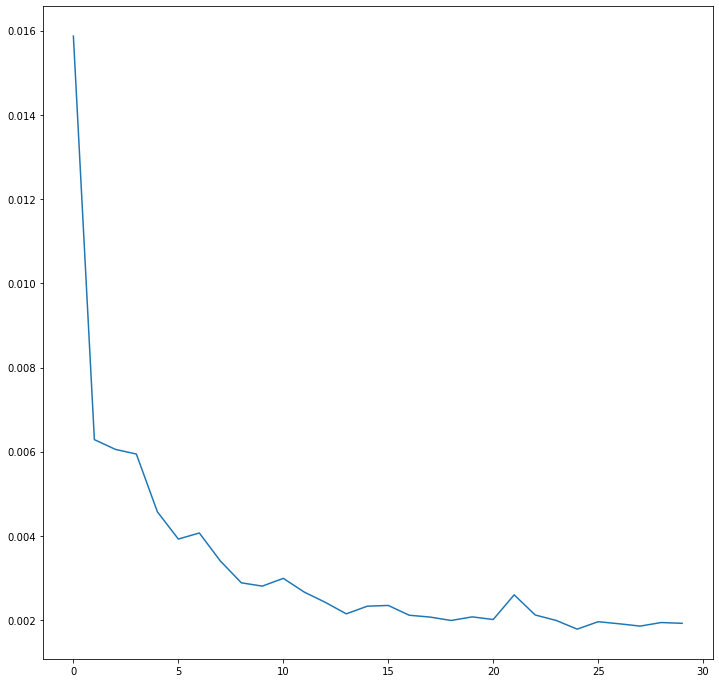

In [208]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.show()

In [209]:
first_eval_batch = scaled_train[-12:]

In [210]:
first_eval_batch

array([[0.18004654],
       [0.17741853],
       [0.18959456],
       [0.15384301],
       [0.15505844],
       [0.13240609],
       [0.15784371],
       [0.13673268],
       [0.13535001],
       [0.16598798],
       [0.16469524],
       [0.1742292 ]])

In [211]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [212]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [213]:
true_predictions = scaler.inverse_transform(test_predictions)

In [214]:
true_predictions

array([[2.31805803],
       [2.22275296],
       [2.12883596],
       [2.03638823],
       [1.9466357 ],
       [1.86129255],
       [1.78094917],
       [1.71408941],
       [1.66607009],
       [1.63943595],
       [1.63621313],
       [1.65540088],
       [1.69493849],
       [1.750288  ],
       [1.81526318],
       [1.88234294],
       [1.94468717],
       [1.99650737],
       [2.03387508],
       [2.05415194],
       [2.05600814],
       [2.0402892 ],
       [2.00983319],
       [1.96776377],
       [1.91905988],
       [1.86900459],
       [1.82260919],
       [1.78399361],
       [1.75643383],
       [1.7420063 ],
       [1.74141821],
       [1.75405783],
       [1.77802323],
       [1.81043924],
       [1.84767088],
       [1.88579406]])

In [215]:
test['Predictions'] = true_predictions

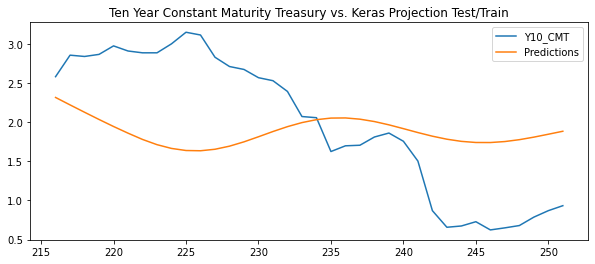

In [216]:
test.plot(figsize=(10,4),title=index_title + ' vs. Keras Projection Test/Train')
plt.show()

In [217]:
error=rmse(test[target_index],test['Predictions'])

In [218]:
print(error)

0.8944412620828748


In [219]:
### Keras projection

In [220]:
train_len = len(df)

In [221]:
train = df.iloc[:train_len]

In [222]:
scaler.fit(train)

MinMaxScaler()

In [223]:
scaled_train = scaler.transform(train)

In [224]:
n_input=12
n_features =1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [225]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [226]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [227]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0132
Epoch 2/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0059
Epoch 3/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 4/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 5/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 6/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 7/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 8/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0027
Epoch 9/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 10/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 11/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 12/30
240/240 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 13/30
240/240 [====

In [228]:
model.history.history.keys()

dict_keys(['loss'])

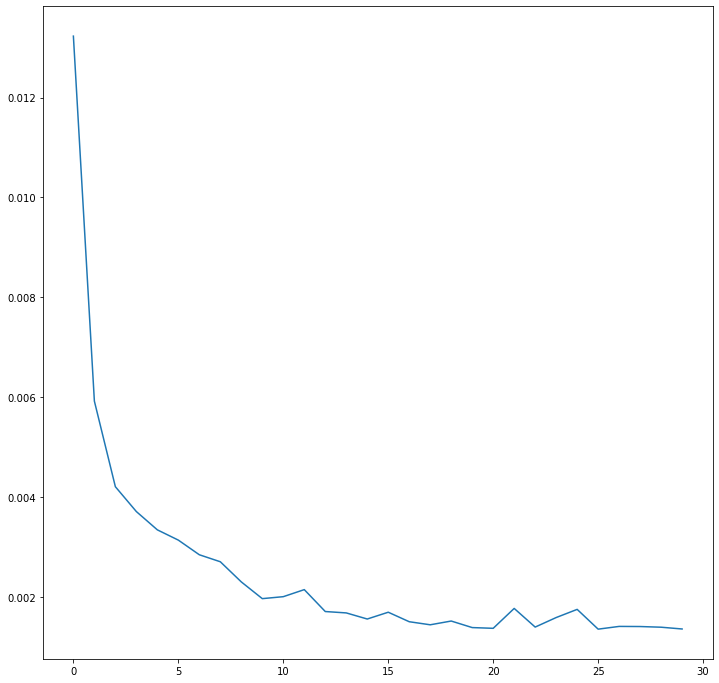

In [229]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [230]:
first_eval_batch = scaled_train[-12:]

In [231]:
first_eval_batch

array([[0.18782746],
       [0.14585409],
       [0.04080649],
       [0.00562873],
       [0.00834199],
       [0.0173917 ],
       [0.        ],
       [0.00436675],
       [0.00925693],
       [0.02708243],
       [0.04080649],
       [0.05134692]])

In [232]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [233]:
future_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(36):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    future_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [234]:
true_predictions = scaler.inverse_transform(test_predictions)

In [235]:
projections=pd.DataFrame(true_predictions)

In [236]:
projections.index = np.arange(252, 252+36)

In [237]:
projections=projections.rename(columns={0: 'Y10_CMT:Proj.'})

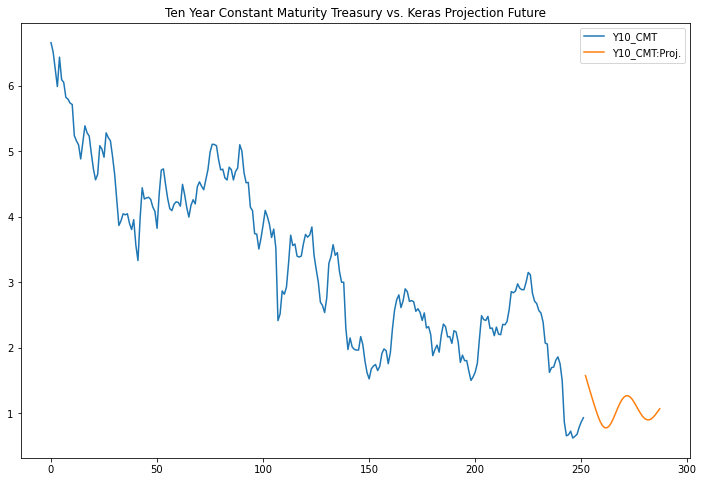

In [238]:
train[target_index].plot(figsize=(12,8), legend=True,title=index_title + ' vs. Keras Projection Future')
projections['Y10_CMT:Proj.'].plot(legend=True)
plt.show()